In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.models import Sequential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [47]:

# Load the dataset
data = pd.read_csv('creditcard.csv')

In [48]:
X = data.drop(['Class'], axis=1)
y = data['Class']

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [49]:
corr_matrix = data.corr()
print(corr_matrix['Class'].sort_values(ascending=False))


Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


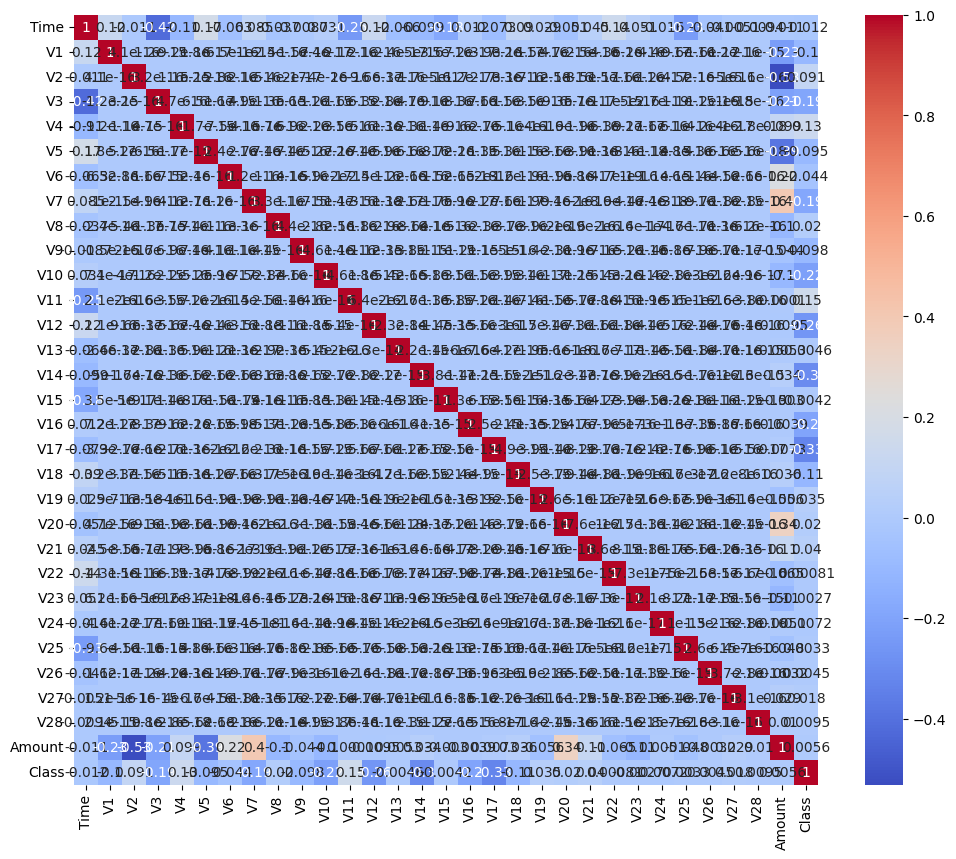

In [50]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

In [51]:
# Split the data into training and testing sets
X_train = data.sample(frac=0.8, random_state=42)
X_test = data.drop(X_train.index)

In [52]:
# Define the deep Q-network model
num_features = data.shape[1] - 1

def build_dqn(input_shape, num_actions):
    input_layer = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_actions)(x)
    model = Model(inputs=input_layer, outputs=x)
    model.compile(optimizer='adam', loss='mse')
    return model
def build(input_shape, output_shape):
    model = Sequential()
    model.add(Dense(64, input_shape=input_shape, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='linear'))
    return model

# Define the DQN training function
def train_dqn(model, env, num_episodes=100, gamma=0.99, epsilon=1.0, epsilon_decay=0.99, batch_size=32):
    memory = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            if np.random.rand() <= epsilon:
                action = np.random.choice([0, 1])
            else:
                Q = model.predict(np.array([state]))
                action = np.argmax(Q[0])
            next_state, reward, done, _ = env.step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
        # Train the model using experience replay
        if len(memory) >= batch_size:
            
            batch_size = 30
            batch_indices = np.random.choice(range(len(memory)), batch_size, replace=False)
            batch = [memory[i] for i in batch_indices]
            X_batch = np.array([np.append(b[0], 0) for b in batch])  # add a new feature with value 0
            X_batch = np.reshape(X_batch, (batch_size, -1))
            y_batch = model.predict(X_batch)
            
            
           # batch_indices = np.random.choice(range(len(memory)), batch_size, replace=False)
            #batch = [memory[i] for i in batch_indices]
           # X_batch = np.array([b[0] for b in batch])
           # X_batch = np.reshape(X_batch, (batch_size, -1))
           # y_batch = model.predict(X_batch)
            X_next_batch = np.array([b[3] for b in batch])
            X_next_batch = np.reshape(X_next_batch, (batch_size, -1))
            Q_next_batch = model.predict(X_next_batch)
            for i, (state, action, reward, next_state, done) in enumerate(batch):
                if not done:
                    y_batch[i][action] = reward + gamma * np.max(Q_next_batch[i])
                else:
                    y_batch[i][action] = reward
            model.train_on_batch(X_batch, y_batch)
        epsilon *= epsilon_decay
        print('Episode:', episode, 'Reward:', total_reward)

# Create the environment
class CreditCardEnvironment:
    def __init__(self, data):
        self.data = data
        self.index = 0
    def reset(self):
        self.index = 0
        state = self.data.iloc[self.index].values[:-1]
        return state
    def step(self, action):
        if action == 0:
            reward = 0
        else:
            reward = self.data.iloc[self.index]['Class']
        self.index += 1
        if self.index >= len(self.data):
            done = True
        else:
            done = False
        next_state = self.data.iloc[self.index].values[:-1]
        return next_state, reward, done, {}

# Train the deep Q-network
env = CreditCardEnvironment(X_train)
input_shape = env.reset().shape
num_actions = 2
model = build


In [53]:
# Build the deep Q-network model
model = build((num_features,), num_actions)


In [54]:
# Normalize the input features
scaler = StandardScaler()
data.iloc[:, 1:-1] = scaler.fit_transform(data.iloc[:, 1:-1])

# Split the data into training and test sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Prepare the training data
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_train = np.hstack((X_train, np.zeros((len(X_train), 1)))).astype(np.float32)
y_train = y_train.astype(np.int32)

# Define the model
model = Sequential([
    Dense(16, input_shape=(31,), activation='relu'),
    Dense(1, activation='sigmoid')
])



# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Prepare the test data
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values
X_test = np.hstack((X_test, np.zeros((len(X_test), 1)))).astype(np.float32)
y_test = y_test.astype(np.int32)

# Evaluate the model on the test set
y_pred = np.round(model.predict(X_test)).astype(np.int32)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)


Epoch 1/5
7121/7121 [==============================] - 11s 1ms/step - loss: 88.9935 - accuracy: 0.9888
Epoch 2/5
7121/7121 [==============================] - 11s 2ms/step - loss: 4.1138 - accuracy: 0.9964
Epoch 3/5
7121/7121 [==============================] - 11s 2ms/step - loss: 3.6041 - accuracy: 0.9963
Epoch 4/5
7121/7121 [==============================] - 10s 1ms/step - loss: 2.9004 - accuracy: 0.9966
Epoch 5/5
1781/1781 [==============================] - 2s 1ms/step
Accuracy on test set: 0.9974895103667422


In [55]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


1781/1781 - 2s - loss: 0.2087 - accuracy: 0.9975 - 2s/epoch - 926us/step
Test loss: 0.20872212946414948
Test accuracy: 0.9974895119667053


Class distribution:
 0    284315
1       492
Name: Class, dtype: int64


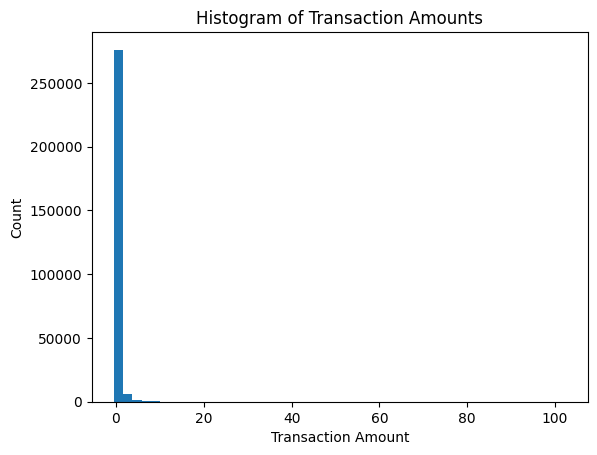

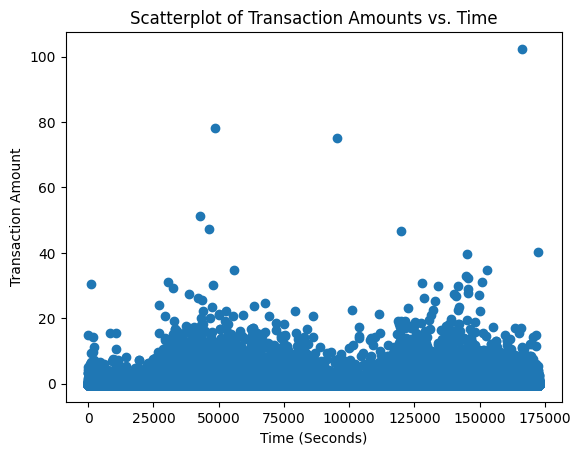

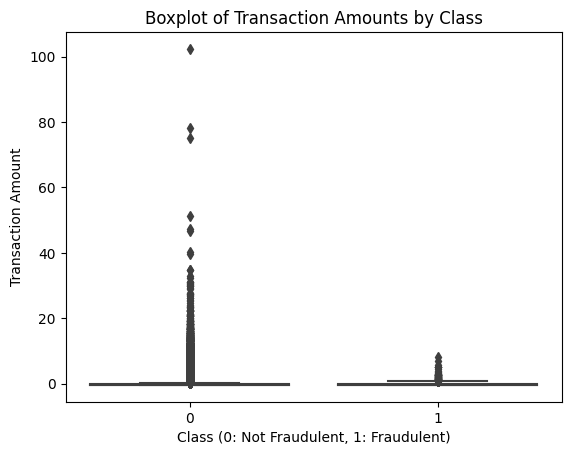

In [56]:
# Print the class distribution of the dataset
print('Class distribution:\n', data['Class'].value_counts())

# Plot the histogram of the transaction amounts
plt.hist(data['Amount'], bins=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Histogram of Transaction Amounts')
plt.show()

# Plot the scatterplot of the transaction amounts vs. time
plt.scatter(data['Time'], data['Amount'])
plt.xlabel('Time (Seconds)')
plt.ylabel('Transaction Amount')
plt.title('Scatterplot of Transaction Amounts vs. Time')
plt.show()

# Plot the boxplot of the transaction amounts by class
sns.boxplot(x='Class', y='Amount', data=data)
plt.xlabel('Class (0: Not Fraudulent, 1: Fraudulent)')
plt.ylabel('Transaction Amount')
plt.title('Boxplot of Transaction Amounts by Class')
plt.show()

In [57]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

1781/1781 [==============================] - 2s 1ms/step
[[56732   124]
 [   19    86]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56856
           1       0.41      0.82      0.55       105

    accuracy                           1.00     56961
   macro avg       0.70      0.91      0.77     56961
weighted avg       1.00      1.00      1.00     56961



Epoch 1/5


C:\Users\Developer\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1781/1781 [==============================] - 5s 3ms/step - loss: 0.1799 - accuracy: 0.9974 - val_loss: 0.1967 - val_accuracy: 0.9981
Epoch 2/5
1781/1781 [==============================] - 4s 2ms/step - loss: 0.2296 - accuracy: 0.9979 - val_loss: 0.1942 - val_accuracy: 0.9987
Epoch 3/5
1781/1781 [==============================] - 3s 2ms/step - loss: 0.1699 - accuracy: 0.9981 - val_loss: 0.2293 - val_accuracy: 0.9917
Epoch 4/5
1781/1781 [==============================] - 4s 2ms/step - loss: 0.2527 - accuracy: 0.9982 - val_loss: 0.1848 - val_accuracy: 0.9984
Epoch 5/5
1781/1781 [==============================] - 4s 2ms/step - loss: 0.1590 - accuracy: 0.9983 - val_loss: 0.1813 - val_accuracy: 0.9984


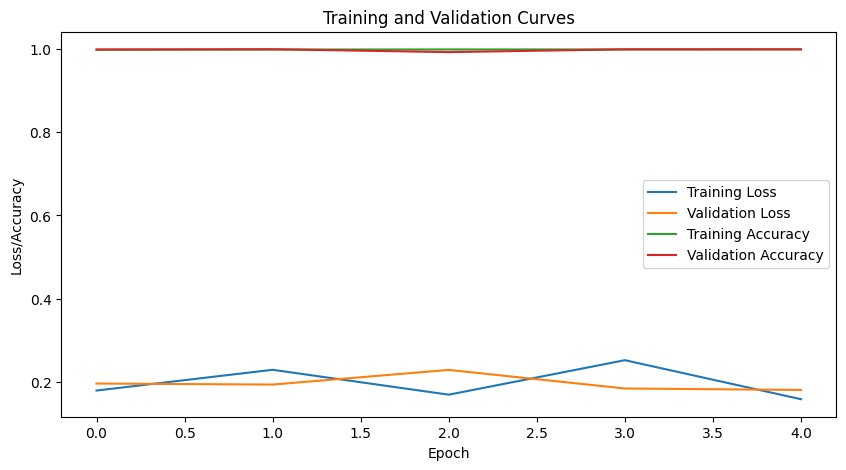

In [58]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

# Save the trained model to a file
model.save('creditcard_fraud_detection_model.h5')

# Plot the training and validation loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

1781/1781 [==============================] - 2s 1ms/step


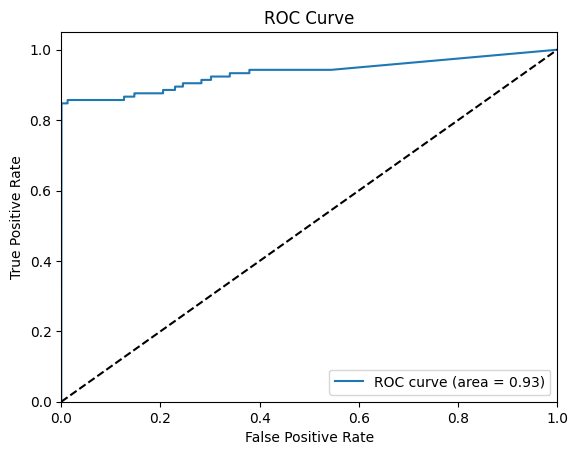

In [59]:
# Calculate the predicted probabilities on the test set
y_pred_prob = model.predict(X_test)

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
